# <div style="text-align: center"> Recurrent Neural Networks (RNN)</div>
#### <div style="text-align: right"> 2019.09.23 Monday</div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Jaewoong Cho, Junhyung Ahn</div>

**실습목표**
- Simple RNN 생성하기
- RNN을 훈련하여 시계열 예측하기 
- Long Short-Term Memory (LSTM)
- LSTM을 훈련하여 문장의 다음 글자 예측하기

In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import backend as K
from sklearn.model_selection import train_test_split

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 1-A. BasicRNNCell 함수 사용하여 RNN 생성하기

In [8]:
# h0 = y0
n_steps = 1 
n_inputs= 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length  = tf.placeholder(tf.int32, [None])

with tf.variable_scope("rnn", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype = tf.float32, 
                                        sequence_length = seq_length)

X_batch  = np.array([[[0,1,2]],    
                     [[3,4,5]],    
                     [[6,7,8]],    
                     [[9,0,1]]])   

seq_length_batch = np.array([1,1,1,1])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    init.run()
    output_vals, states_val = sess.run([outputs, states], 
                                       feed_dict= {X: X_batch , seq_length: seq_length_batch})

output_vals = output_vals.reshape(output_vals.shape[0],output_vals.shape[2])
print("Output: \n {} \n".format(output_vals))
print("States: \n {}\n".format(states_val))
print("Output == States? \n {}".format(output_vals==states_val))

Output: 
 [[ 0.43176767  0.5482154  -0.86434966  0.56038374  0.5489826 ]
 [ 0.8276491  -0.4616098  -0.9795521   0.9967786   0.9060194 ]
 [ 0.95616776 -0.9238276  -0.9970714   0.9999816   0.98343873]
 [ 0.30016604 -0.9999814   0.98829347  0.9575828  -0.08290724]] 

States: 
 [[ 0.43176767  0.5482154  -0.86434966  0.56038374  0.5489826 ]
 [ 0.8276491  -0.4616098  -0.9795521   0.9967786   0.9060194 ]
 [ 0.95616776 -0.9238276  -0.9970714   0.9999816   0.98343873]
 [ 0.30016604 -0.9999814   0.98829347  0.9575828  -0.08290724]]

Output == States? 
 [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


In [9]:
# 정적으로 타임 스텝 펼치기
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 =  tf.placeholder(tf.float32, [None, n_inputs])

# 미니배치
X0_batch = np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]]) #t=0
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]]) #t=1

with tf.variable_scope("rnn", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
    output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell,[X0,X1],dtype=tf.float32)
    Y0,Y1 = output_seqs

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    Y0_val, Y1_val = sess.run([Y0,Y1], feed_dict = {X0: X0_batch, X1:X1_batch})
    
print("Y0_val: \n{}".format(Y0_val)) # t=0에서 출력
print("Y1_val: \n{}".format(Y1_val)) # t=1에서 출력

Y0_val: 
[[ 0.80473197 -0.93374103 -0.34794635  0.30171108 -0.7344416 ]
 [ 0.9634274  -0.99994963  0.8311196   0.95033884 -0.99655   ]
 [ 0.9936071  -0.9999998   0.9918045   0.9975856  -0.9999609 ]
 [-0.73411024 -0.6986788   0.9998829   0.542608   -0.9937409 ]]
Y1_val: 
[[ 0.99217063 -1.          0.9998882   0.99985206 -0.9996916 ]
 [ 0.6947066  -0.12046456  0.61854374  0.22363791  0.9072764 ]
 [ 0.89100903 -0.99997944  0.99961287  0.9943949  -0.9664566 ]
 [-0.28205147 -0.99702054  0.9977043   0.6444405  -0.79240215]]


In [5]:
# 가변 길이 시퀀스 입력
n_steps = 2

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length  = tf.placeholder(tf.int32, [None])
with tf.variable_scope("rnn", reuse=tf.AUTO_REUSE):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype = tf.float32, sequence_length = seq_length)

X_batch  = np.array([
                     # t = 0  # t = 1
                     [[0,1,2],[9,8,7]],    # 샘플 0
                     [[3,4,5],[0,0,0]],    # 샘플 1
                     [[6,7,8],[6,5,4]],    # 샘플 2
                     [[9,0,1],[3,2,1]]])   # 샘플 3

seq_length_batch = np.array([2,1,2,2])

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    init.run()
    output_vals, states_val = sess.run([outputs, states], feed_dict= {X: X_batch , seq_length: seq_length_batch})
    
print("Output: \n {} \n".format(output_vals))
print("States: \n {}".format(states_val))

Output: 
 [[[-0.61635274  0.6478881   0.49444214 -0.8819403   0.91511047]
  [ 0.08124901  0.9999985   0.13071336 -1.          1.        ]]

 [[-0.6908321   0.99349755  0.51423025 -0.9999653   0.9999816 ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.7530615   0.9999004   0.53348565 -1.          1.        ]
  [ 0.08116708  0.99994326 -0.01200833 -0.9999966   0.9999953 ]]

 [[ 0.5035339   0.247873   -0.7249967  -0.99844426  0.99881756]
  [ 0.07877089  0.97740036  0.07343581 -0.99244636  0.9942239 ]]] 

States: 
 [[ 0.08124901  0.9999985   0.13071336 -1.          1.        ]
 [-0.6908321   0.99349755  0.51423025 -0.9999653   0.9999816 ]
 [ 0.08116708  0.99994326 -0.01200833 -0.9999966   0.9999953 ]
 [ 0.07877089  0.97740036  0.07343581 -0.99244636  0.9942239 ]]


In [6]:
def plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(14,8))
    ax1, ax2 = axes.ravel()
    
    ax1.plot(history.history["loss"], label="Training loss")
    ax1.plot(history.history["val_loss"], label="Validation loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(history.history["acc"], label="Training accuracy")
    ax2.plot(history.history["val_acc"], label="Validation accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Sccuracy")
    ax2.legend()

## 1-B. 시계열 예측을 위해 훈련하기

In [7]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) 
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   
    return series[..., np.newaxis].astype(np.float32)

In [8]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [9]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

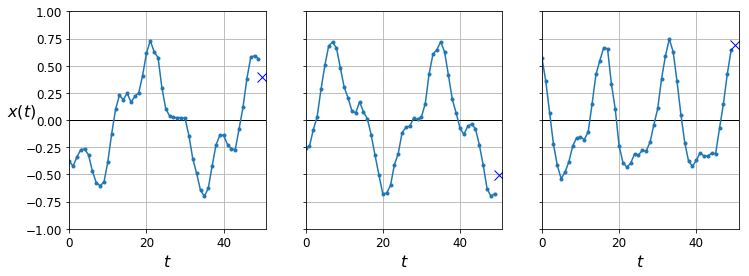

In [10]:
def plot_series(series, y=None, y_pred=None, 
                x_label="$t$", 
                y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10, label='Actual')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro",label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True,
                         figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### 1. Simple RNN

In [11]:
np.random.seed(42)

simple_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

simple_rnn_model.compile(loss="mse", optimizer="adam")
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 220us/sample - loss: 0.2008 - val_loss: 0.1903
Epoch 2/20
7000/7000 [==============================] - 1s 205us/sample - loss: 0.1666 - val_loss: 0.1590
Epoch 3/20
7000/7000 [==============================] - 1s 209us/sample - loss: 0.1399 - val_loss: 0.1334
Epoch 4/20
7000/7000 [==============================] - 1s 208us/sample - loss: 0.1159 - val_loss: 0.1083
Epoch 5/20
7000/7000 [==============================] - 1s 204us/sample - loss: 0.0932 - val_loss: 0.0861
Epoch 6/20
7000/7000 [==============================] - 1s 207us/sample - loss: 0.0734 - val_loss: 0.0670
Epoch 7/20
7000/7000 [==============================] - 1s 207us/sample - loss: 0.0562 - val_loss: 0.0507
Epoch 8/20
7000/7000 [==============================] - 1s 204us/sample - loss: 0.0419 - val_loss: 0.0373
Epoch 9/20
7000/7000 [==============================] - 1s 202us/sample - loss: 0.0305 - val_loss: 0.027

In [12]:
def plot_loss_curves(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history["loss"], label = "Training loss")
    plt.plot(history.history["val_loss"], label = "Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

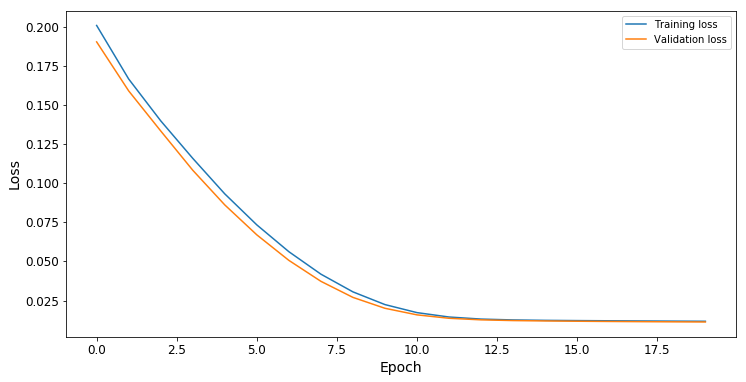

In [13]:
plot_loss_curves(simple_rnn_history)

In [14]:
simple_rnn_model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 54us/sample - loss: 0.0113


0.011300665125250816

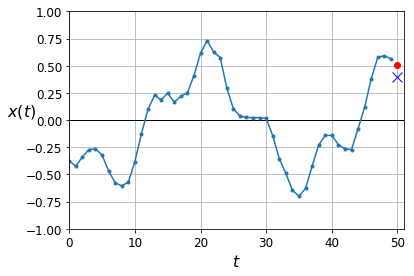

In [15]:
simple_rnn_y_pred = simple_rnn_model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], simple_rnn_y_pred[0, 0])
plt.show()

In [16]:
print("Simple RNN Error: {}".format(y_valid[0,0] - simple_rnn_y_pred[0,0]))

Simple RNN Error: -0.1096467673778534


###  2. LSTM

In [17]:
np.random.seed(42)

lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, 
                      input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

lstm_model.compile(loss="mse", optimizer="adam")
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0510 - val_loss: 0.0325
Epoch 2/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0218 - val_loss: 0.0142
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0120 - val_loss: 0.0106
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0072 - val_loss: 0.0044
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0037 - val_loss: 0.0031
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 7/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0030 - val_loss: 0.0029
Epoch 8/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0029 - val_loss: 0.0030
Epoch 9/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 1

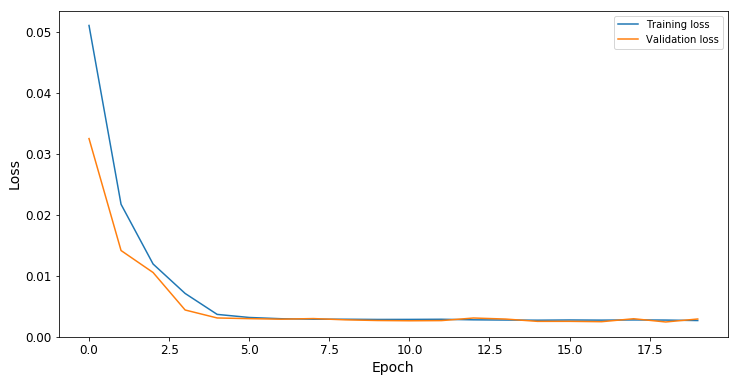

In [18]:
plot_loss_curves(lstm_history)

In [19]:
lstm_model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 318us/sample - loss: 0.0030


0.0029764097575098276

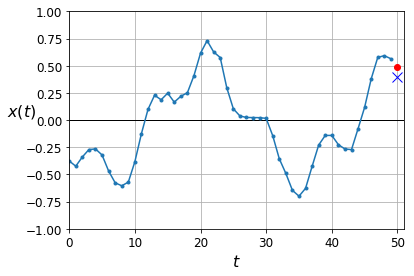

In [20]:
lstm_y_pred = lstm_model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], lstm_y_pred[0, 0])
plt.show()

In [21]:
print("LSTM Error: {}".format(y_valid[0,0] - lstm_y_pred[0,0]))

LSTM Error: -0.0878763198852539


## 1-F. LSTM 이용하여 다음 글자 예측하기

In [22]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [23]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [24]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [25]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [26]:
max_id = len(tokenizer.word_index) 
dataset_size = tokenizer.document_count 

In [27]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 1 // 100

In [28]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [29]:
n_steps = 100
window_length = n_steps + 1 
dataset = dataset.repeat().window(window_length, shift=1, 
                                  drop_remainder=True)

In [30]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [31]:
np.random.seed(42)

In [32]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [33]:
dataset = dataset.map(lambda X_batch, Y_batch: 
                      (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [34]:
dataset = dataset.prefetch(1)

In [36]:
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, dropout = 0.5, return_sequences=True, 
                      input_shape=[None, max_id]),
    keras.layers.LSTM(20, dropout = 0.5, return_sequences=True),
    keras.layers.Dense(max_id, activation="softmax")
])

lstm_model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam")
lstm_history = lstm_model.fit(dataset, 
                    steps_per_epoch=train_size // batch_size, 
                    epochs=10)

Epoch 1/10
348/348 [==============================] - 50s 142ms/step - loss: 3.1422
Epoch 2/10
348/348 [==============================] - 48s 138ms/step - loss: 3.0076
Epoch 3/10
348/348 [==============================] - 48s 139ms/step - loss: 2.8284
Epoch 4/10
348/348 [==============================] - 48s 139ms/step - loss: 2.7011
Epoch 5/10
348/348 [==============================] - 48s 139ms/step - loss: 2.6382
Epoch 6/10
348/348 [==============================] - 48s 139ms/step - loss: 2.5832
Epoch 7/10
348/348 [==============================] - 48s 139ms/step - loss: 2.5407
Epoch 8/10
348/348 [==============================] - 49s 140ms/step - loss: 2.5050
Epoch 9/10
348/348 [==============================] - 48s 139ms/step - loss: 2.4788
Epoch 10/10
348/348 [==============================] - 48s 139ms/step - loss: 2.4555


In [38]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [39]:
X_new = preprocess(["How are yo"])
sess = tf.Session()
with sess.as_default():
    X_new = X_new.eval()

In [43]:
lstm_Y_pred = lstm_model.predict_classes(X_new)
tokenizer.sequences_to_texts(lstm_Y_pred + 1)[0][-1] 

'u'